# **1. Multi-class Weather Dataset**
[Multi-class Weather Dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)은 다양한 기상 조건을 포함하는 이미지 데이터셋으로, 주로 기계 학습 및 딥러닝 모델을 학습하거나 평가하는 데 사용됩니다. 이 데이터셋은 맑음, 비, 눈, 흐림과 같은 여러 날씨 유형으로 라벨이 지정된 다중 클래스 분류 문제를 다룹니다. 각 클래스는 다양한 시간대, 계절, 지역에서 촬영된 이미지를 포함하여 현실 세계의 다양성을 반영하도록 설계되었습니다. 이를 통해 모델은 날씨 조건을 정확히 분류하고, 기상 관측, 자동화된 날씨 보고, 혹은 자율주행 차량의 환경 인식 시스템과 같은 다양한 응용 분야에서 활용될 수 있습니다.

In [1]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/91.4M [00:00<?, ?B/s]
100% 91.4M/91.4M [00:00<00:00, 1.03GB/s]


In [3]:
import os
import zipfile
import random
from shutil import copyfile, rmtree  # rmtree: 폴더를 통째로 삭제

zip_file = 'multiclass-weather-dataset.zip'
train_dir = './train'
test_dir = './test'

In [4]:
# zipfile 모듈을 사용해서 ZIP 파일 압축을 해제(풀기)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')

# zip_file: 압축 해제할 .zip 파일 경로 또는 파일 객체
# zip_ref: 열어둔 ZIP 파일 객체를 임시 이름으로 사용
# with 문을 쓰는 이유: 사용 후 자동으로 파일 닫기(자원 정리)
# zip_ref.extractall('.'): ZIP 파일 안의 모든 파일과 폴더를 현재 디렉토리 (.) 에 압축 해제
# extractall('폴더이름')을 쓰면 지정된 폴더에 풀 수도 있다.

In [5]:
# 분류 디렉터리 목록
categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

In [6]:
if os.path.exists(train_dir):
    rmtree(train_dir)
if os.path.exists(test_dir):
    rmtree(test_dir)

# 중복/오염된 데이터를 방지하고, 재실행할 때 동일한 결과를 보장하기 위해 폴더 전체를 삭제한다.

In [7]:
# train, test 폴더 및 하위 카테고리 폴더 생성
os.makedirs(train_dir, exist_ok=True)     # exist_ok = True : 있으면 냅둬라
os.makedirs(test_dir, exist_ok=True)

In [8]:
# 각 카테고리별 데이터 파일 나누기
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

In [9]:
base_dir = '/content/Multi-class Weather Dataset'

In [10]:
# 각 카테고리별 데이터 파일 나누기
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path)
    # 베이스 디렉토리의 각각의 카테고리를 돌면서 그 안에 들어있는 파일들을 모두 리스트로 가져와라
    # print(files)

    # 데이터 섞기
    random.shuffle(files)
    # print(len(files))

    # 데이터 나누기 (8:2 비율)
    split_idx = int(len(files)*.8)    # trainData: 80%, testData: 20%
    # print(split_idx)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # 파일 복사(이유: 데이터 분할, 구조 유지, 원본 보호, 반복실험 가능)
    for file in train_files:
        src = os.path.join(category_path, file)         # 원본 파일 경로
        dst = os.path.join(train_dir, category, file)  # 복사할 목적지 경로
        copyfile(src, dst)                                            # src에서 dst로 복사

    for file in test_files:
        src=os.path.join(category_path, file)
        dst = os.path.join(test_dir, category, file)
        copyfile(src, dst)

print("데이터 분리가 완료되었습니다.")

데이터 분리가 완료되었습니다.


In [11]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [12]:
transform_train = transforms.Compose([  # 여러 이미지 전처리(transformation) 작업을 순차적으로 묶어주는 역할
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(),  # 랜덤 좌우 반전 → 데이터 증강
    transforms.ToTensor(),  # 이미지 → 텐서 (0~1)
    transforms.Normalize(   # 정규화
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])  #  테스트에서는 일관된 결과를 위해 데이터 증강 금지

**※ transforms.ToTensor()**

- 이미지를 PyTorch 텐서(tensor)로 변환합니다.
- 이미지의 픽셀 값을 [0, 255] 범위에서 [0.0, 1.0] 범위로 정규화합니다.
- 이미지의 차원을 (H, W, C) 형식에서 PyTorch에서 사용하는 (C, H, W) 형식으로 바꿉니다.
    - H: 이미지의 높이 (Height)
    - W: 이미지의 너비 (Width)
    - C: 채널(Channel; 예: RGB 이미지의 경우 3)


**※ transforms.Normalize(mean, std)**

- 텐서로 변환된 이미지의 픽셀 값을 정규화(normalization)합니다.
- mean: 각 채널(R, G, B)의 평균값.
- std: 각 채널의 표준편차.
- mean=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 평균을 0.5로 설정.
- std=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 표준편차를 0.5로 설정.
- 이 정규화는 일반적으로 픽셀 값의 범위를 [−1,1][-1, 1][−1,1]로 조정하기 위해 사용됩니다. (픽셀 값이 [0,1][0, 1][0,1]로 변환된 상태에서)

> 렐루에서 조금 더 좋은 결과를 보인다.

In [13]:
# 훈련용 데이터셋 불러오기
train_dataset = datasets.ImageFolder(
    root = 'train/',
    transform = transform_train
)
# datasets.ImageFolder: 폴더 구조에 따라 이미지를 자동으로 라벨링해주는 데이터셋 클래스
# root='train/': 이미지가 저장된 최상위 디렉토리 경로
# transform=transform_train: 이미지에 적용할 전처리 함수


**※ ImageFolder**

- datasets.ImageFolder는 이미지 데이터를 특정 디렉터리 구조에서 로드하는 클래스입니다.
- 디렉터리 이름을 레이블(class label)로 간주하며, 각 디렉터리 내의 이미지 파일들을 해당 레이블에 할당합니다.
- 이 클래스는 이미지 데이터를 PyTorch 데이터셋(Dataset) 형식으로 변환하므로, DataLoader와 함께 사용하여 배치 처리 및 데이터 증강(data augmentation)을 쉽게 적용할 수 있습니다.

In [14]:
dataset_size = len(train_dataset)
# print(dataset_size)  # 899

train_size = int(dataset_size*0.8)
val_size = dataset_size - train_size
# print(train_size, val_size)  # 719, 180

# 데이터셋을 훈련용과 검증용으로 무작위 분할
# train_dataset: 원래 전체 데이터셋
# [train_size, val_size]: 훈련과 검증 데이터로 나눌 샘플 수
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

719 180


In [15]:
# 테스트 데이터셋 불러오기
test_dataset = datasets.ImageFolder(
    root = 'test/',
    transform = transform_test
)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

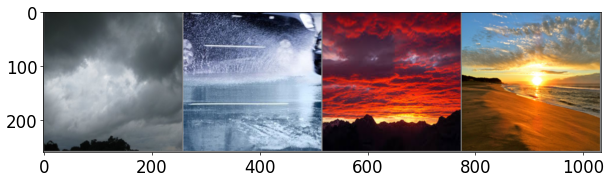

['Cloudy', 'Rain', 'Sunrise', 'Sunrise']


In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    input = input.numpy().transpose((1, 2, 0))   # torch.Tensor => numpy
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean # 정규화 해제 (역정규화) (연습용)
    input = np.clip(input, 0, 1) # 값이 0보다 작은 경우 0, 1보다 큰 경우 1로 변환합니다.
    plt.imshow(input)
    plt.show()

class_names = {
    0:"Cloudy", 1:"Rain", 2:"Shine", 3:"Sunrise"
}

iterator = iter(train_dataloader)
imgs, labels = next(iterator)
out = make_grid(imgs[:4]) # 여러 이미지(0 ~ 3)를 하나의 격자 형태로 합침
imshow(out)

print([class_names[labels[i].item()] for i in range(4)])

# **다양한 모델 만들기**

Model1: 단일 선형 계층 분류 모델

In [18]:
# 단일 선형 계층
# 활성화 함수나 추가 계층이 없으므로 모델이 표현할 수 있는 함수는 단순 선형 변환에 제한
# (256*256*3+1)*4 = 786,436
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256*256*3, 4)   #256x256x3 이미지 → Cloudy, Rain, Shine, Sunrise 4개 클래스 분류
        self.flatten = nn.Flatten()                       # 이미지 -> 1차원 벡터로 변환

  # 순전파(입력 → 예측값 반환)
    def forward(self, x):
        x = self.flatten(x)                                    # [B, 3, 256, 256] -> [B, 196608]
        x = self.linear1(x)                                    # [B, 196608] -> [B, 4]
        return x                                                   # 예측 결과 출력

완전 연결 레이어 (= FC레이어, Linear Layer)
: 모든 입력 노드가 모든 출력 노드와 연결된 레이어
예를들어, 입력 벡터가 3개 노드: [x1, x2, x3], 출력 벡터가 2개 노드: [y1, y2]. 완전 연결레이어는 이 모든 입력값이 각 출력 노드와 전부 연결되어 아래처럼 계산된다.
```
y1 = w11*x1 + w12*x2 + w13*x3 + b1
y2 = w21*x1 + w22*x2 + w23*x3 + b2
```


flatten을 사용하는 이유: 이미지를 완전연결레이어에 넣기 전에 1차원 벡터로 변환하기 위해서.

Model2: 2층 선형 계층 분류 모델

In [19]:
# 두 개의 선형 계층을 사용하여 입력 데이터를 단계적으로 압축
# (256*256*3+1)*64 + (64+1)*4 = 12,583,236
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256*256*3, 64)  # 입력 → 중간층
        self.linear2 = nn.Linear(64, 4)                 # 중간층 → 출력층
        self.flatten = nn.Flatten()                         # 이미지 → 벡터

    def forward(self, x):
        x = self.flatten(x)  # [B, 3, 256, 256] → [B, 196608]
        x = self.linear1(x)  # [B, 196608] → [B, 64] (큰 입력 벡터 → 중간 피처 64차원으로 압축)
        x = self.linear2(x)  # [B, 64] → [B, 4] (중간 피처 → 최종 출력(클래스 4개))
        return x

Model3: 다층 퍼셉트론 구조에 드롭아웃 적용

In [20]:
# 다중 구조와 ReLU 활성화 함수를 사용하여 비선형적 특징을 학습할 수 있음
# Dropout을 통해 과적합을 방지
# (256*256*3+1)*128 + (128+1)*64 + (64+1)*32 + (32+1)*4 = 25176420
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256*256*3, 128)  # 노드가 128개
        self.dropout1 = nn.Dropout(0.5)  # 0.5확률로 기울기를 0으로 만들어서 64개만 학습(과적합 방지)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x


**※ Dropout**

nn.Dropout()은 PyTorch에서 제공하는 과적합(overfitting)을 방지하기 위한 레이어입니다. 드롭아웃은 학습 과정 중 일부 뉴런을 무작위로 "비활성화(drop)"함으로써, 모델이 특정 뉴런에 지나치게 의존하지 않도록 도와줍니다. 이를 통해 모델의 일반화 성능이 향상됩니다.

In [21]:
def train():
    start_time = time.time()
    print(f'[Epoch {epoch+1} - Training]')

    model.train()  # 모델을 학습 모드로 설정
    total = 0  # 총 샘플 수
    running_loss = 0.0  # 누적 손실
    running_corrects = 0  # 예측 정답 수

    for i, batch in enumerate(train_dataloader):  # 학습용 데이터 배치를 하나씩 가져온다.
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()  # 이미지와 레이블을 GPU로 옮긴다.

        # 순전파
        outputs = model(imgs)  # 순전파 (forward pass)를 통해 모델이 예측값(outputs)을 생성
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스를 예측(preds)으로 선택
        loss = criterion(outputs, labels)  # 손실 함수(criterion)로 실제값과 예측값 간의 손실(loss)을 계산

        # 역전파 및 가중치 갱신
        optimizer.zero_grad()  # 기존의 gradient 초기화
        loss.backward()  # 역전파 수행
        optimizer.step()  # 최적화 알고리즘으로 가중치 업데이트

        # 통계 계산
        total += labels.shape[0]  # 전체 샘플 수 업데이트
        running_loss += loss.item()  # 손실값 누적
        running_corrects += torch.sum(preds == labels.data)  # 예측이 맞은 개수를 누적 (정확도 계산용)

        # 중간 손실, 정확도 출력
        if i % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] Loss: {current_loss:.4f}, Accuracy: {current_acc:.4f}')

    # 에폭 종료 후 최종 성능 출력
    epoch_loss = running_loss / total  # 한 에폭 동안의 전체 평균 손실, 정확도 계산
    epoch_acc = running_corrects.double() / total
    print(f'[Epoch Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print("Elapsed time:", time.time() - start_time)

    return epoch_loss, epoch_acc.item()  # 에폭의 평균 손실, 정확도 반환
    # .item()은 tensor를 Python float으로 바꾸기 위함이다.


이 함수는 다음을 수행합니다:

모델을 학습 모드로 설정

데이터를 순회하며 예측, 손실 계산, 역전파 수행

배치별로 손실/정확도 출력 (log)

에폭 전체에 대한 평균 손실과 정확도 출력

최종 손실과 정확도 반환

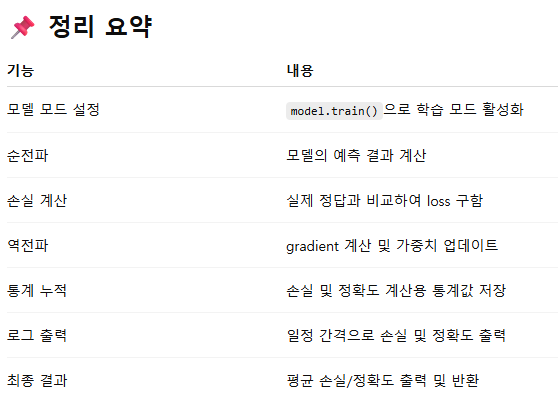

In [22]:
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')

    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch {i + 1}] Loss: {current_loss:.4f}, Accuracy: {current_acc:.4f}')

    # 에폭 전체에 대한 평균 손실/정확도 출력
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'[Validation Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print("Elapsed time:", time.time() - start_time)

    return epoch_loss, epoch_acc.item()

In [23]:
def test():
    start_time = time.time()
    print(f'[Test]')

    model.eval()  # 모델을 테스트(평가) 모드로 전환
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            total += labels.shape[0]
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            if i % log_step == 0:
                current_loss = running_loss / total
                current_acc = running_corrects.double() / total
                print(f'[Batch {i + 1}] Loss: {current_loss:.4f}, Accuracy: {current_acc:.4f}')

        # 전체 테스트 결과 출력
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        print(f'[Test Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        print("Elapsed time:", time.time() - start_time)

        return epoch_loss, epoch_acc.item()

In [24]:
# 목적: 훈련이 진행될수록 학습률을 줄여서 모델이 초기에는 빠르게 학습하고, 후반에는 더 정교하게 미세조정하도록 유도하는 함수.
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10  # 에폭이 3이상이면 학습률을 1/10로 감소.
    if epoch >= 7:
        lr /= 10  # 에폭이 7이상이면 다시 1/10 감소(결과적으로 원래의 1/100 감소)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr